In [1]:
import torch
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
train_df: pd.DataFrame = pd.read_pickle('out/train.pkl')
test_df: pd.DataFrame = pd.read_pickle('out/test.pkl')

test_df

,id,ts,mission,ID,history,negatives
91360,12_2024-11-01,2024-11-01,quiz_2,25,"[[13, 0], [0, 1], [4, 1], [29, 1], [3, 1], [18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
91362,30_2024-11-01,2024-11-01,streak_1,30,"[[24, 1], [13, 1], [10, 1], [1, 1], [15, 1], [...","[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
91363,30_2024-11-01,2024-11-01,activity_6,8,"[[24, 1], [13, 1], [10, 1], [1, 1], [15, 1], [...","[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
91380,51_2024-11-01,2024-11-01,quiz_1,24,"[[21, 0], [4, 1], [15, 1], [7, 1], [17, 1], [1...","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16..."
91381,51_2024-11-01,2024-11-01,episode_2,13,"[[21, 0], [4, 1], [15, 1], [7, 1], [17, 1], [1...","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16..."
...,...,...,...,...,...,...
110911,8066_2024-11-07,2024-11-07,episode_3,14,"[[30, 1], [13, 1], [28, 1], [1, 0], [4, 1], [2...","[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
110917,8078_2024-11-07,2024-11-07,streak_1,30,"[[24, 0], [16, 0], [6, 0]]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
110949,8131_2024-11-07,2024-11-07,activity_3,5,"[[24, 1], [1, 0], [3, 0], [26, 1], [8, 1], [19...","[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
110950,8131_2024-11-07,2024-11-07,quiz_4,27,"[[24, 1], [1, 0], [3, 0], [26, 1], [8, 1], [19...","[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [3]:
missions = train_df[['ID', 'mission']] \
    .drop_duplicates() \
    .sort_index()

missions['type'] = missions['mission'].str.split('_').str[0]
missions['target'] = missions['mission'].str.split('_').str[1]
missions.drop(columns=['mission'], inplace=True)
missions.to_csv('data/missions.csv', index=False)
missions = missions.to_dict(orient='records')
missions

[{'ID': 30, 'type': 'streak', 'target': '1'},
 {'ID': 6, 'type': 'activity', 'target': '4'},
 {'ID': 25, 'type': 'quiz', 'target': '2'},
 {'ID': 14, 'type': 'episode', 'target': '3'},
 {'ID': 10, 'type': 'activity', 'target': '8'},
 {'ID': 3, 'type': 'activity', 'target': '10'},
 {'ID': 19, 'type': 'exp', 'target': '50'},
 {'ID': 0, 'type': 'action', 'target': '1'},
 {'ID': 4, 'type': 'activity', 'target': '2'},
 {'ID': 26, 'type': 'quiz', 'target': '3'},
 {'ID': 7, 'type': 'activity', 'target': '5'},
 {'ID': 16, 'type': 'episode', 'target': '5'},
 {'ID': 17, 'type': 'episode', 'target': '6'},
 {'ID': 2, 'type': 'activity', 'target': '1'},
 {'ID': 5, 'type': 'activity', 'target': '3'},
 {'ID': 15, 'type': 'episode', 'target': '4'},
 {'ID': 20, 'type': 'mobility', 'target': '1'},
 {'ID': 29, 'type': 'quiz', 'target': '6'},
 {'ID': 18, 'type': 'exp', 'target': '100'},
 {'ID': 27, 'type': 'quiz', 'target': '4'},
 {'ID': 9, 'type': 'activity', 'target': '7'},
 {'ID': 21, 'type': 'mobility'

In [4]:
import os
from src.gru4rec import GRU4Rec, SequentialRecommendations, train

model = GRU4Rec(n_items=len(missions), hidden_size=16, n_layers=2)

pad_token = max(m['ID'] for m in missions) + 1
dataset = SequentialRecommendations(train_df, pad_value=pad_token)
validation = SequentialRecommendations(test_df, pad_value=pad_token)
model, train_loss, validation_loss = train(model, dataset, validation, n_epochs=50, reg_lambda=0.01, lr=0.001)

os.makedirs('models', exist_ok=True)
torch.save(model, 'models/gru4rec.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

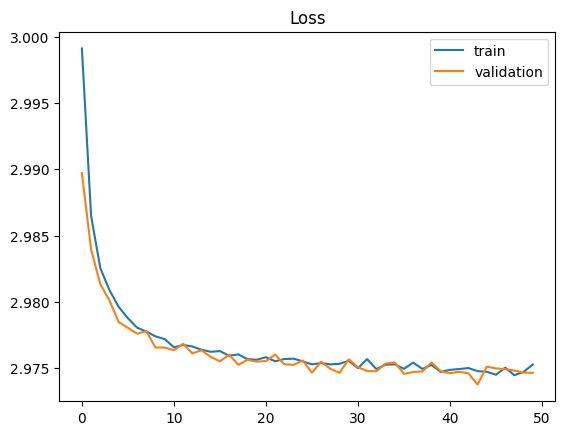

In [6]:
from matplotlib import pyplot as plt

plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.legend()

plt.show()